Using the Spotify and YouTube dataset (linked here: https://www.kaggle.com/datasets/salvatorerastelli/spotify-and-youtube), I will analyze the key factors that contribute to a song's popularity on Spotify by identifying the features that influence stream counts.

The dataset contains songs from various artists worldwide, with details on Spotify statistics, including streams, and the YouTube views of their official music videos. While the dataset includes 26 variables, my analysis will focus on the following key features:

* Artist, Track, Album, Album Type (metadata)

* Danceability, Energy, Key, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo, Duration (ms) (audio characteristics)

The target variable for this analysis is "Streams", representing a song’s popularity on Spotify

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [121]:
path = r"C:\Users\Maria Arunkumar\Documents\Spotify_and_Youtube\Spotify_Youtube.csv"

In [122]:
Songs_data = pd.read_csv(path)

In [123]:
Songs_data.columns

Index(['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Album_type',
       'Uri', 'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
       'Comments', 'Description', 'Licensed', 'official_video', 'Stream'],
      dtype='object')

I am removing columns that contain YouTube data and any features that are not directly relevant to the analysis of Spotify streams in order to focus on the key factors influencing song popularity on Spotify. This will streamline the dataset.

In [124]:
Spotify_wstream = Songs_data[[
    #'Unnamed: 0', 
    'Artist', 
    #'Url_spotify', 
    'Track', 'Album', 
    'Album_type',
    #'Uri', 
    'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
    'Duration_ms', 
    #'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
    #'Comments', 'Description', 'Licensed', 'official_video', 
    'Stream']].copy()
Spotify_wstream.columns

Index(['Artist', 'Track', 'Album', 'Album_type', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream'],
      dtype='object')

Now, I will be performing data cleaning, which includes handling missing values, duplicates, and outliers to ensure a high-quality dataset for modeling.

In [125]:
Spotify_wstream.shape

(20718, 16)

In [126]:
Spotify_wstream.dtypes

Artist               object
Track                object
Album                object
Album_type           object
Danceability        float64
Energy              float64
Key                 float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
Duration_ms         float64
Stream              float64
dtype: object

In [127]:
Spotify_wstream.isna().sum()

Artist                0
Track                 0
Album                 0
Album_type            0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Duration_ms           2
Stream              576
dtype: int64

In [128]:
Spotify_wstream[Spotify_wstream['Danceability'].isna()]

,Artist,Track,Album,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Stream
11890,Natasha Bedingfield,These Words,Unwritten,album,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110442210.0
13843,White Noise for Babies,Rain in the Early Morning,Soothing Rain for Background Sounds and Natura...,album,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145339552.0


These two rows don't have any values for any of the features and therefore being removed from the dataset

In [129]:
Spotify_wstream = Spotify_wstream.drop([11890, 13843],axis=0)
Spotify_wstream.isna().sum()

Artist                0
Track                 0
Album                 0
Album_type            0
Danceability          0
Energy                0
Key                   0
Loudness              0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
Duration_ms           0
Stream              576
dtype: int64

Imputing the target variable can introduce bias, distort true relationships, and create data leakage, leading to misleading model performance. Since the missing data only makes up 2.78% of the dataset, I will be removing the missing datapoints to maintain data integrity.

In [130]:
Spotify_wstream = Spotify_wstream.dropna(subset=['Stream'])

In [131]:
Spotify_wstream.isna().sum()

Artist              0
Track               0
Album               0
Album_type          0
Danceability        0
Energy              0
Key                 0
Loudness            0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Duration_ms         0
Stream              0
dtype: int64

In [132]:
Spotify_wstream.loc[Spotify_wstream['Track']=="DON'T YOU WORRY"]

,Artist,Track,Album,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Stream
91,Black Eyed Peas,DON'T YOU WORRY,ELEVATION,album,0.831,0.868,11.0,-5.282,0.0325,0.176,0.0,0.184,0.483,131.971,194438.0,162685755.0
155,Shakira,DON'T YOU WORRY,ELEVATION,album,0.831,0.868,11.0,-5.282,0.0325,0.176,0.0,0.184,0.483,131.971,194438.0,162685755.0
8029,David Guetta,DON'T YOU WORRY,ELEVATION,album,0.831,0.868,11.0,-5.282,0.0325,0.176,0.0,0.184,0.483,131.971,194438.0,162685755.0


There are duplicates found. If a track has featured artists the row duplicates for each individual artist on the track. To address this, I will categorize artists into two groups: "Single" for solo artists and "Feature" for artists who are featured on a track. This will help streamline the data and prevent redundancy.

In [133]:
all_duplicate_rows = Spotify_wstream.duplicated(subset=['Track', 'Album', 'Album_type'], keep=False)
duplicate_records = Spotify_wstream[all_duplicate_rows]
duplicate_records['Artist'] = 'Feature'
cleaned_records = duplicate_records.drop_duplicates(subset=['Track', 'Album', 'Album_type'], keep='first')
Spotify_wstream = Spotify_wstream[~all_duplicate_rows]
Spotify_wstream = pd.concat([Spotify_wstream, cleaned_records], ignore_index=True)
Spotify_wstream.loc[Spotify_wstream['Artist'] != 'Feature', 'Artist'] = 'Solo'

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\934193666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_records['Artist'] = 'Feature'


In [134]:
cleaned_records.loc[cleaned_records['Track']=="DON'T YOU WORRY"]

,Artist,Track,Album,Album_type,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Stream
91,Feature,DON'T YOU WORRY,ELEVATION,album,0.831,0.868,11.0,-5.282,0.0325,0.176,0.0,0.184,0.483,131.971,194438.0,162685755.0


I will proceed with data transformation, converting specific numerical features into categorical variables based on their descriptions.

For example:

Speechiness: This attribute detects the presence of spoken words in a track.

* Values above 0.66 indicate tracks that are likely entirely spoken (e.g., audiobooks, talk shows).
    
* Values between 0.33 and 0.66 suggest a mix of music and speech (e.g., rap songs).
    
* Values below 0.33 primarily represent musical tracks.
    
* I will categorize this feature into "Music," "Mixture," and "Speech."

Liveness: This measures the likelihood that a track was recorded in front of an audience.

* Values above 0.8 strongly suggest a live performance.
    
* Lower values indicate a studio recording.
    
* I will categorize this feature into "Live" and "Studio."

In [135]:
#Liveness: A value above 0.8 provides strong likelihood that the track is live

def Liveness_Value(data):
    if data <= 0.8:
        return 'Studio'
    elif data > 0.8:
        return 'live'
    else:
        return 'Unknown'
    
Spotify_wstream['Liveness'] = Spotify_wstream['Liveness'].apply(Liveness_Value)

In [136]:
 #Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

def Speechiness_Value(data):
    if 0 <= data < 0.33:
        return 'Music'
    elif 0.33 <= data <= 0.66:
        return 'Mixture'
    elif 0.66 < data <= 1.0:
        return 'Speech'
    else:
        return 'Unknown'
        
Spotify_wstream['Speechiness'] = Spotify_wstream['Speechiness'].apply(Speechiness_Value)

In [137]:
Spotify = Spotify_wstream[[
    'Artist', 
    #'Track', 'Album', 
    'Album_type', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream']].copy()

In [138]:
Categorical = [feature for feature in Spotify if Spotify[feature].dtype == "O" and feature not in ['Stream']]
Numerical = [feature for feature in Spotify if Spotify[feature].dtype != "O" and feature not in ['Stream']]
Discrete = [feature for feature in Numerical if len(Spotify[feature].unique())<25]
Continuous =[feature for feature in Numerical if feature not in Discrete]

In [139]:
for feature in Categorical:
    data=Spotify_wstream.copy()
    print(feature,"",len(data[feature].unique()))
 # Remove Track and Albumb as they don't provide meaningful information and adding them to the model will make it too complex

Artist  2
Album_type  3
Speechiness  3
Liveness  2


I am removing the variables Track and Album from the dataset because they contain a high number of unique values, which can introduce unnecessary noise and complexity to the analysis. Since these features do not contribute meaningful patterns for determining song popularity, removing them will help streamline the analysis and improve model effectiveness.

I will conduct exploratory data analysis (EDA) to examine the distribution of features and their relationship with the target variable (Streams) to identify trends and patterns that influence a song’s popularity on Spotify.

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\2255087633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Spotify, x=feature, palette='viridis')


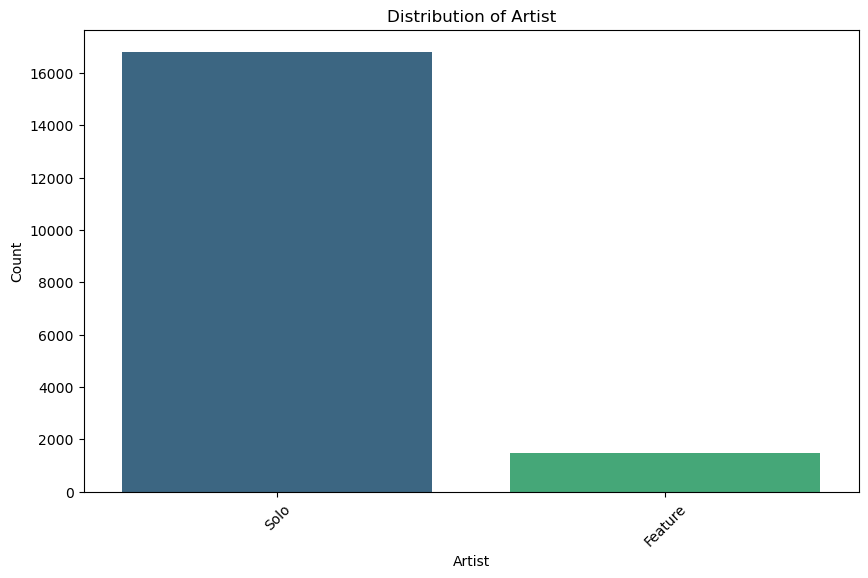

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\2255087633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Spotify, x=feature, palette='viridis')


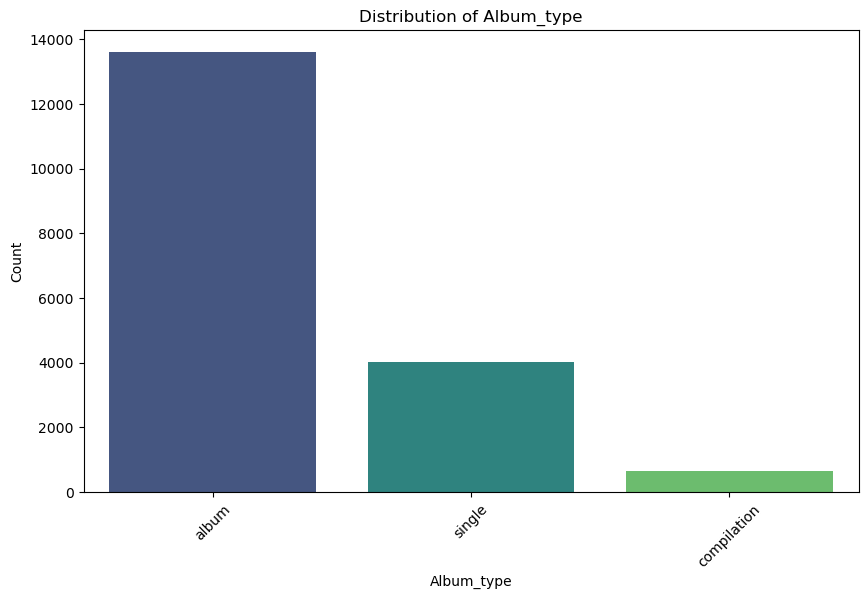

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\2255087633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Spotify, x=feature, palette='viridis')


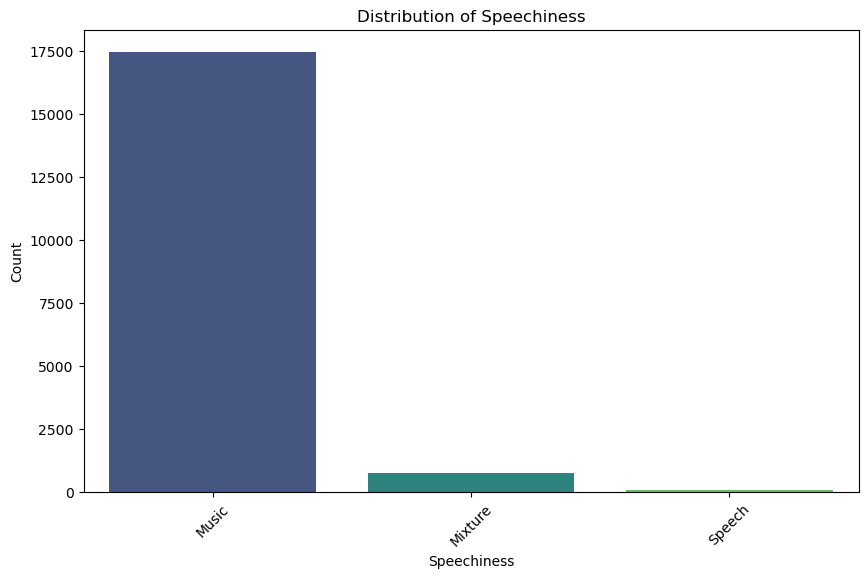

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\2255087633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Spotify, x=feature, palette='viridis')


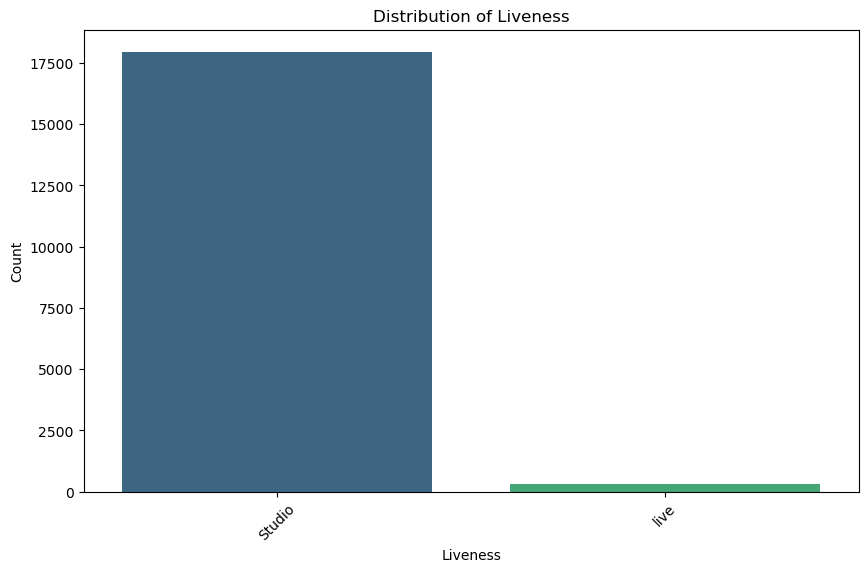

In [140]:
for feature in Categorical:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=Spotify, x=feature, palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

The dataset reveals a clear trend toward studio-based productions with a strong emphasis on music rather than speech-like tracks.
Additionally, most songs are performed by solo artists, with featured artists forming a smaller subset of the dataset.

C:\Users\Maria Arunkumar\AppData\Local\Temp\ipykernel_17576\3687197280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='pastel')


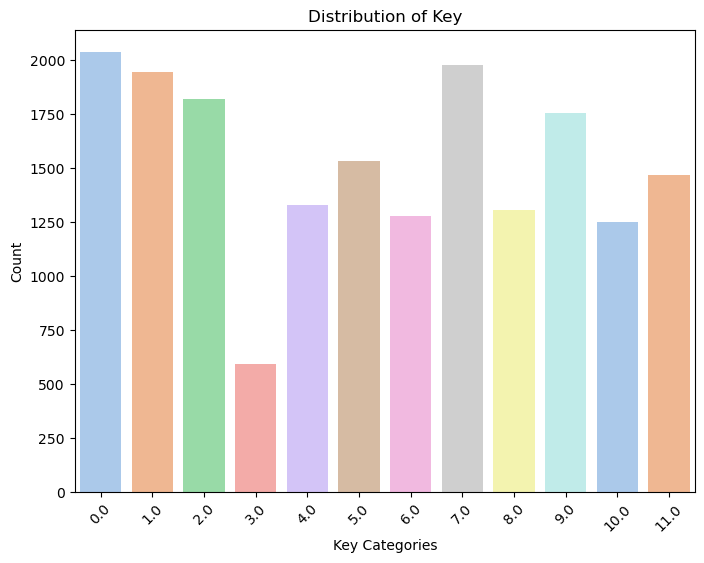

In [141]:
for feature in Discrete:
    plt.figure(figsize=(8, 6))
    
    # Count the occurrences of each unique value
    value_counts = Spotify[feature].value_counts()
    
    # Create a bar graph for the feature
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='pastel')
    plt.xlabel(f'{feature} Categories')
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

Most songs in the dataset are in the key of C major, highlighting a common tonal choice among tracks in this datset.

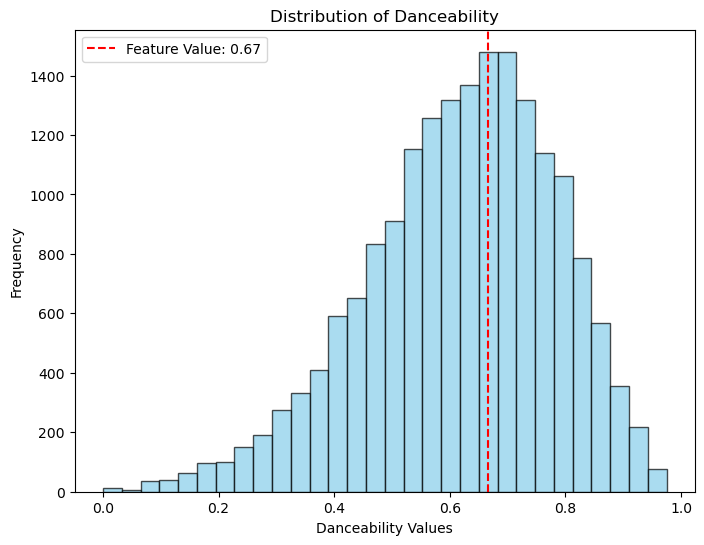

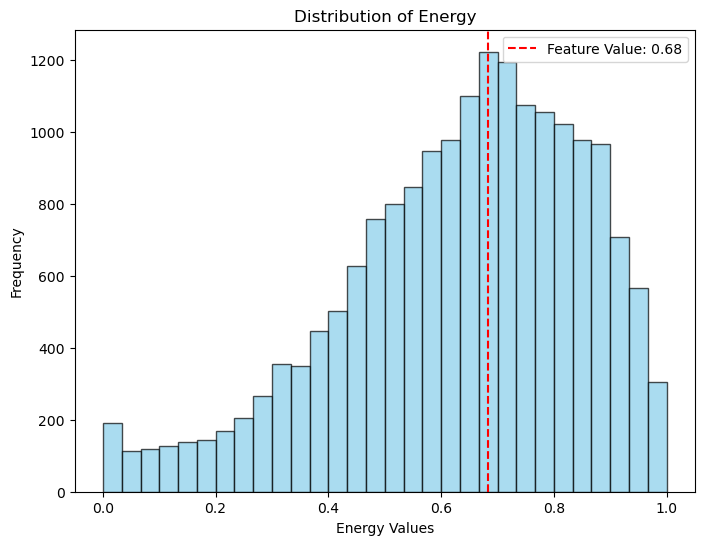

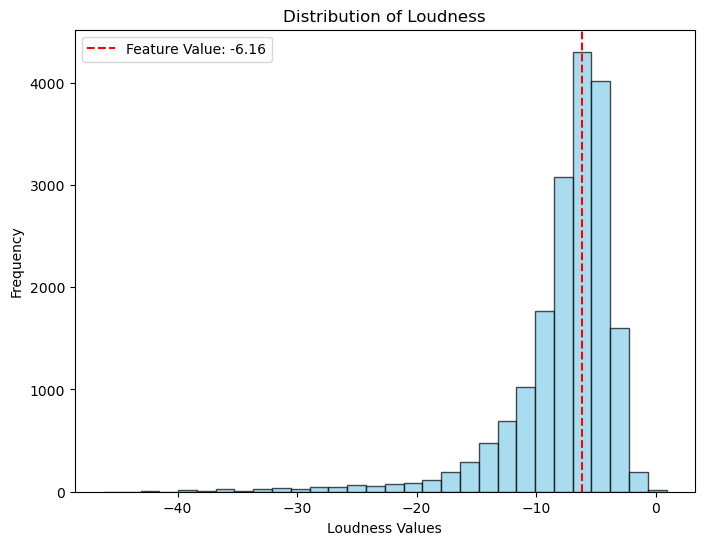

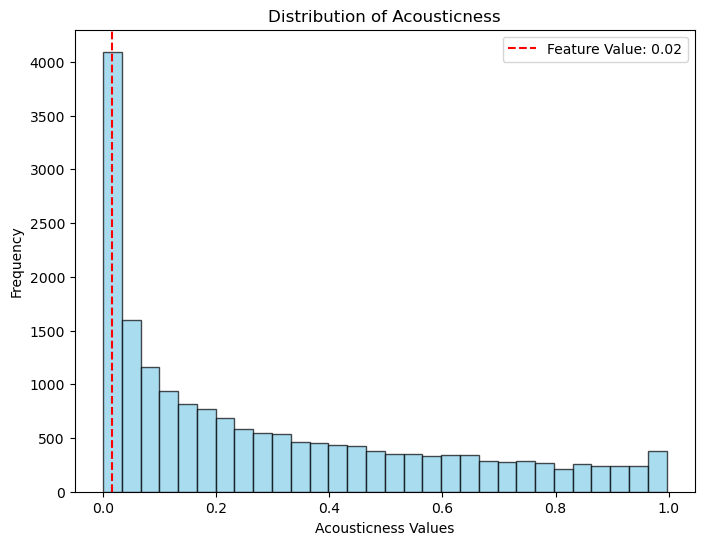

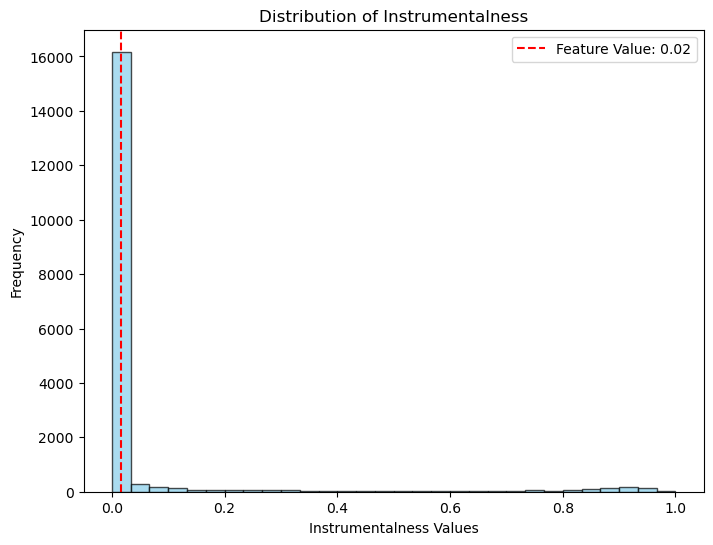

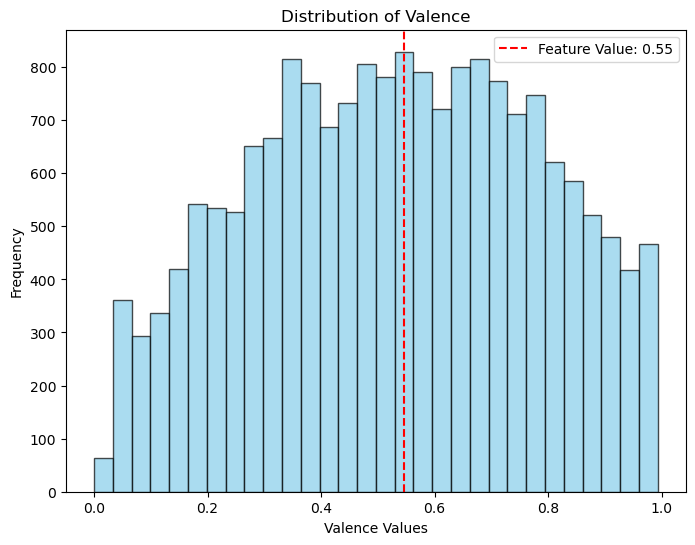

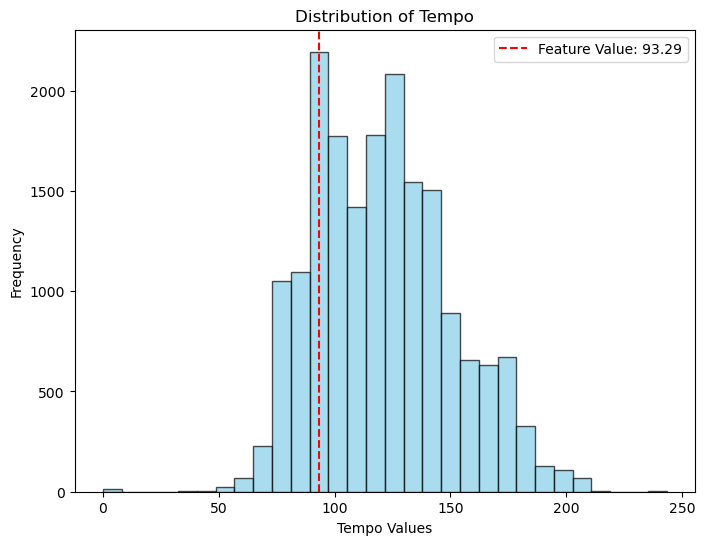

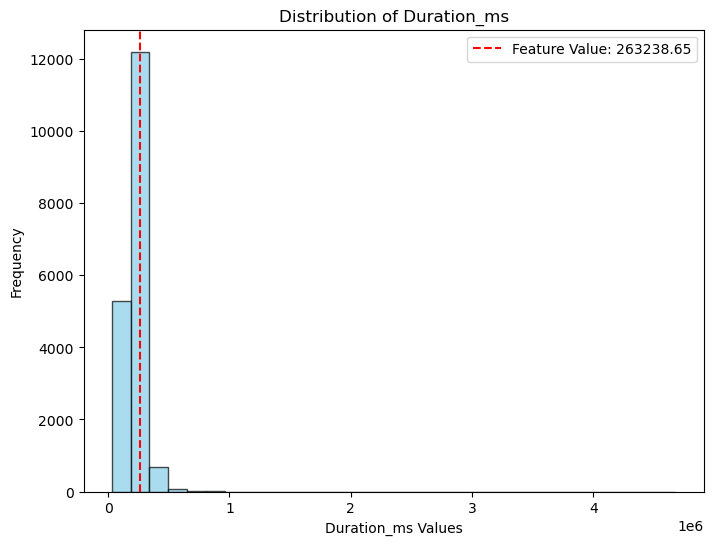

In [142]:
for feature in Continuous:
    plt.figure(figsize=(8, 6))
    
    # Create a histogram and capture the bin counts and edges
    counts, bins, _ = plt.hist(Spotify[feature], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
    
    # Find the bin with the highest frequency
    max_freq = counts.max()
    max_bin_index = counts.argmax()  # Index of the bin with the highest frequency
    max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2  # Calculate the center of the bin

    # Add a vertical line for the bin with the highest frequency
    plt.axvline(max_bin_center, color='red', linestyle='--', label=f'Feature Value: {max_bin_center:.2f}')
    
    # Add labels and title  
    plt.xlabel(f'{feature} Values')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.legend()  # Display the legend to show the feature value
    plt.show()


Based on the dataset, most songs exhibit the following trends:

* High Danceability, Energy, and Loudness: The majority of songs are designed to have a strong rhythmic drive. Probably made to engage listeners in active or lively environments, such as clubs or parties.
* Low Acousticness and Instrumentalness:: This implies a preference for mainstream pop, electronic, or hip-hop genres where vocals and electronic production are dominant.
* Average Valence and Tempo: Indicating that they appeal to a wide range of moods and listeners.

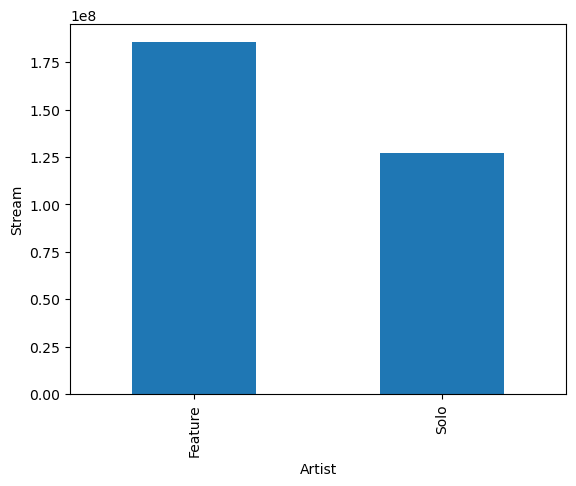

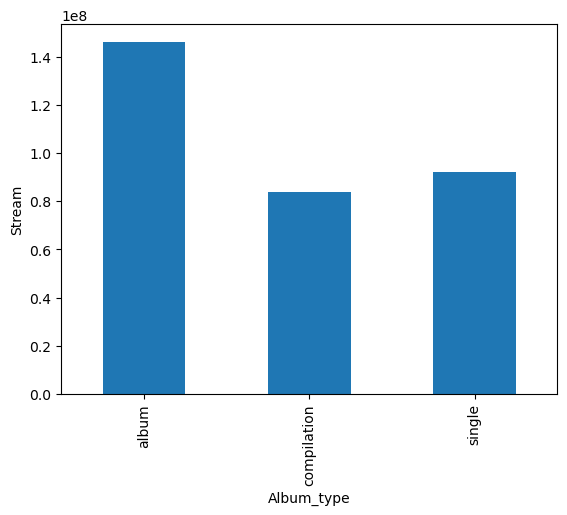

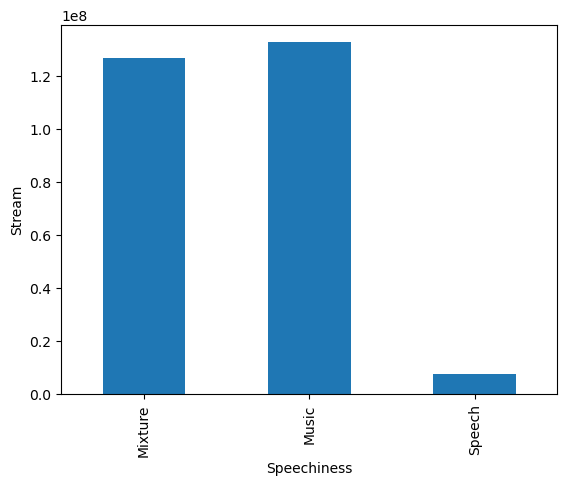

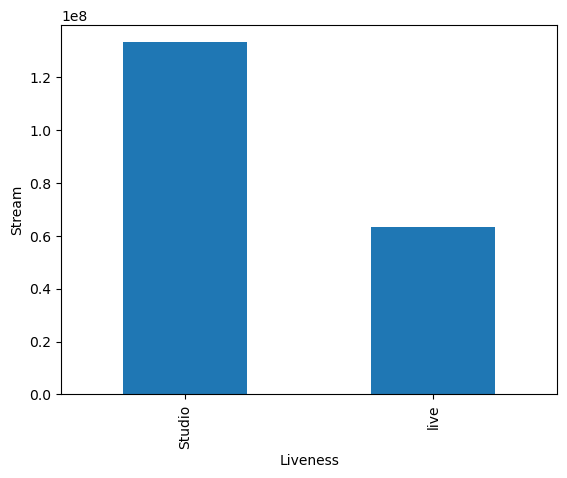

In [143]:
for feature in Categorical:
    data=Spotify.copy()
    data.groupby(feature)['Stream'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Stream')
    plt.show()

The analysis indicates that songs with featured artists generally perform better in terms of streams. Albums that combine music with speech tend to show higher performance, suggesting that this blend resonates well with listeners. And studio versions of songs consistently outperform live versions, highlighting the preference for polished, studio-produced tracks over live recordings.

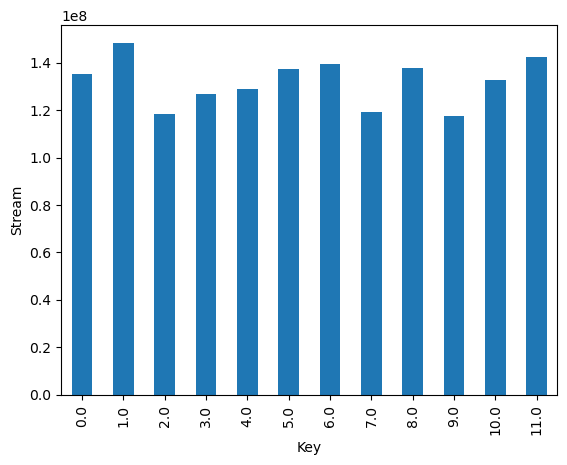

In [144]:
for feature in Discrete:
    data=Spotify.copy()
    data.groupby(feature)['Stream'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Stream')
    plt.show()

The analysis reveals no significant correlation between the musical key of a song and its stream count. This lack of relationship suggests that the key does not influence the popularity of a track, and including it in the model could introduce unnecessary noise. Therefore, to streamline the analysis, the "Key" feature will be excluded from the dataset.

In [145]:
Spotify = Spotify_wstream[[
    'Artist', 
    #'Track', 'Album', 
    'Album_type', 'Danceability', 'Energy',
       #'Key', 
    'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream']].copy()

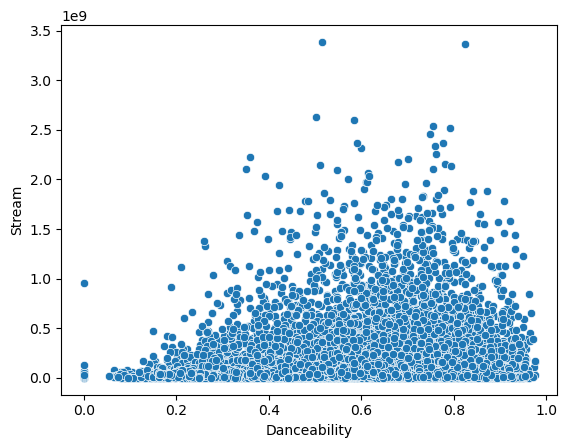

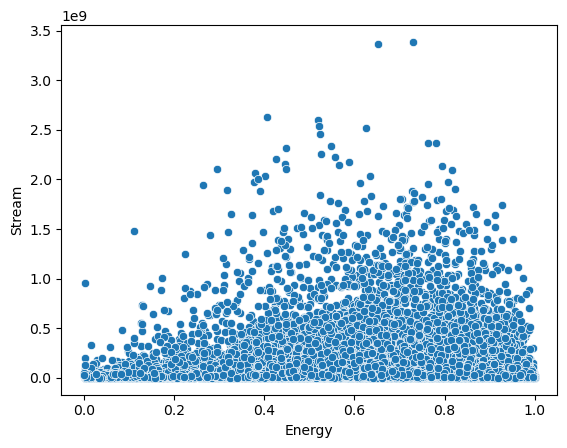

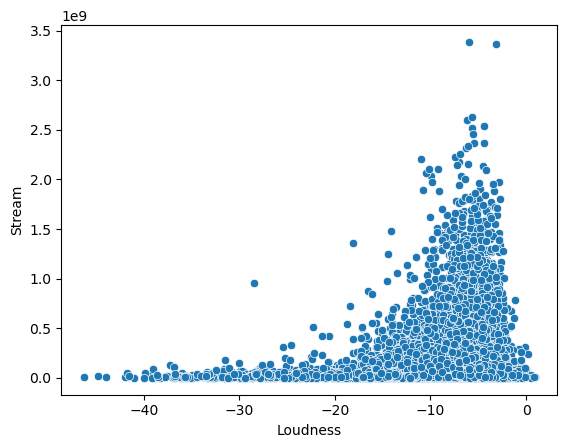

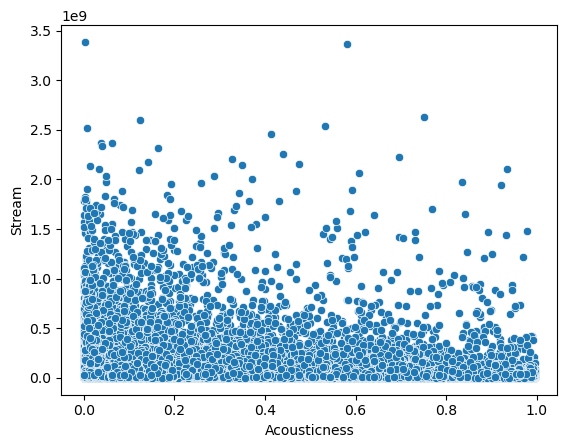

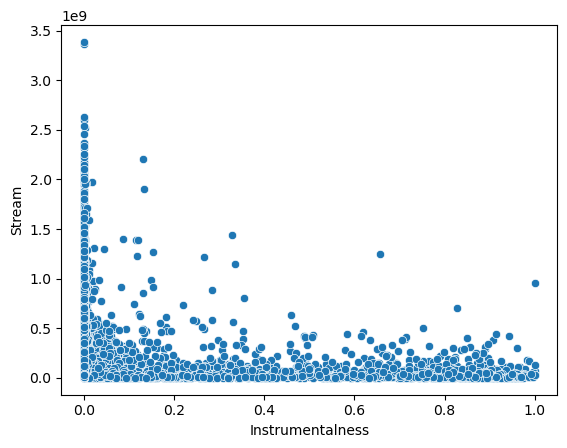

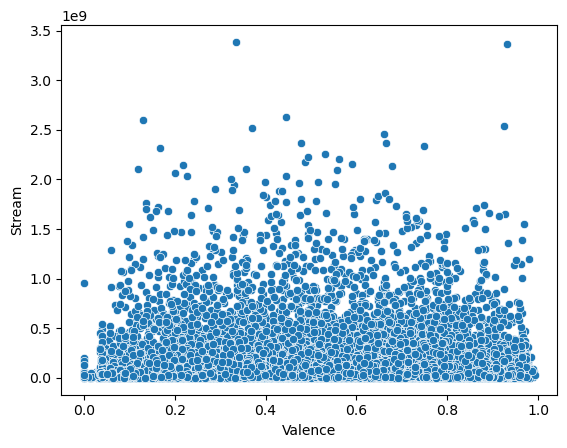

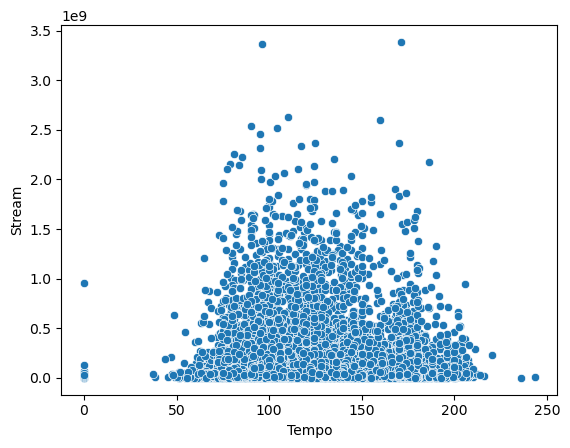

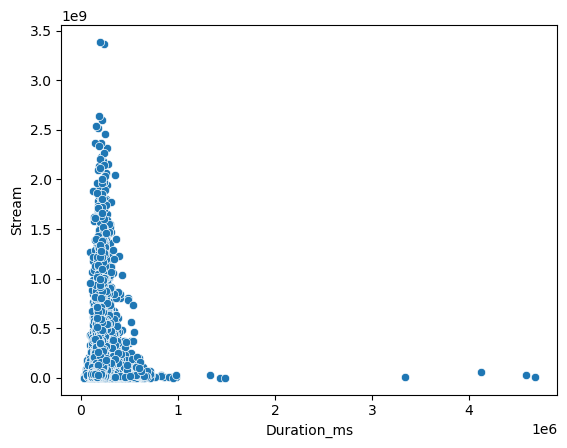

In [146]:
for feature in Continuous:
    sns.scatterplot(data=Spotify, x=feature, y='Stream')
    plt.xlabel(feature)
    plt.ylabel('Stream')
    plt.show()

The analysis indicates that most continuous variables exhibit a non-linear relationship with the stream count. Additionally, variables like Loudness, Tempo and Duration lack a fixed range between 0 and 1. Feature scaling will be applied to normalize these variables to fit within the 0-1 range, reducing the impact of extreme values, ensuring the data is prepared for modeling.

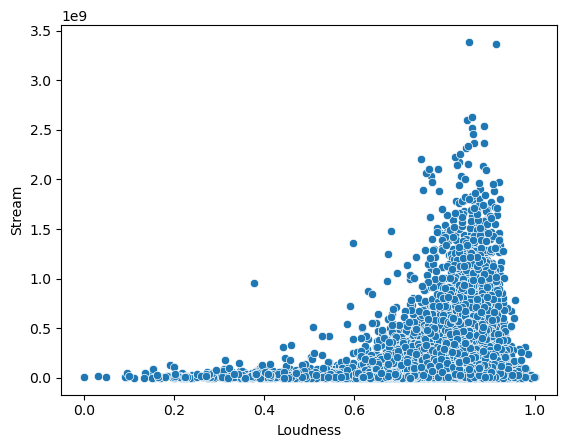

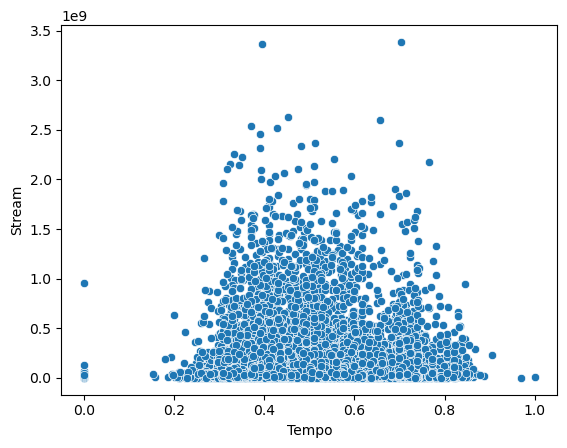

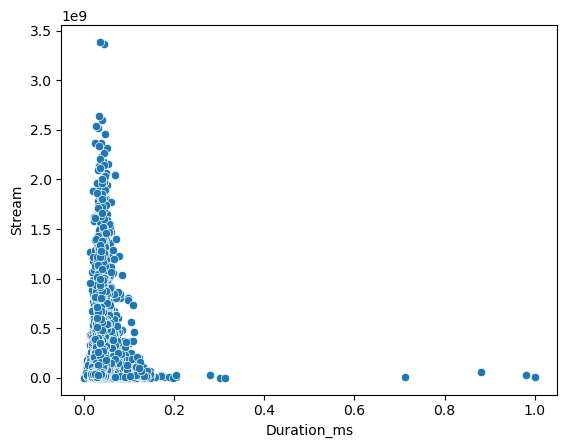

In [147]:
columns_to_normalize = ['Loudness', 'Tempo', 'Duration_ms']

scaler = MinMaxScaler()

Spotify[columns_to_normalize] = scaler.fit_transform(Spotify[columns_to_normalize])

for feature in columns_to_normalize:
    sns.scatterplot(data=Spotify, x=feature, y='Stream')
    plt.xlabel(feature)
    plt.ylabel('Stream')
    plt.show()

The target variable appears to have outliers. I will be removing these outliers to ensure that the model is not overly influenced by extreme values.
Additionaly, the target variable seems to have a skewed distribution. To address this, a log transformation will be applied to reducing skewness. This improves the model's ability to detect patterns and relationships more effectively, as many machine learning algorithms ( like the one we will be using) assume a normal distribution of the target variable. Furthermore, target variable with a large spread of values, in turn, may result in large error gradient values causing weight values to change dramatically or might explode and hence making the learning process unstable.

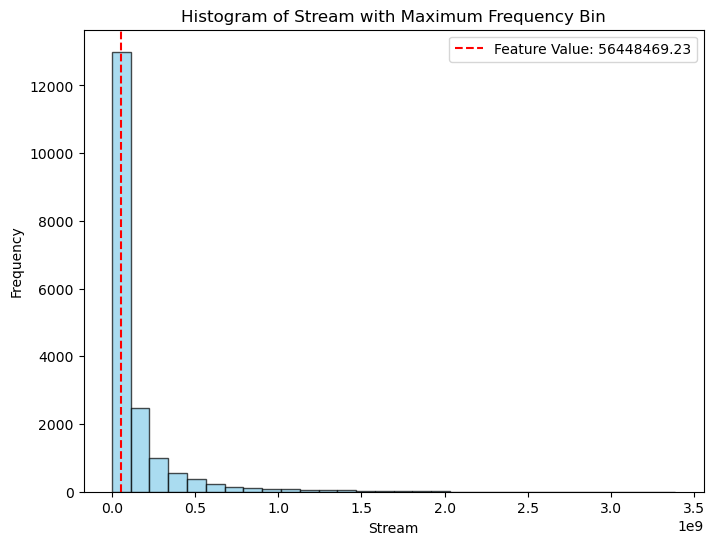

In [148]:
plt.figure(figsize=(8, 6))

counts, bins, _ = plt.hist(Spotify['Stream'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')

max_freq = counts.max()
max_bin_index = counts.argmax()
max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

plt.axvline(max_bin_center, color='red', linestyle='--', label=f'Feature Value: {max_bin_center:.2f}')

plt.xlabel('Stream')
plt.ylabel('Frequency')
plt.title('Histogram of Stream with Maximum Frequency Bin')
plt.legend()

plt.show()


In [149]:
Q1 = Spotify['Stream'].quantile(0.25)
Q3 = Spotify['Stream'].quantile(0.75)
IQR = Q3 - Q1
    
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
outliers = (Spotify['Stream'] < lower_bound).sum()
outliers2 = (Spotify['Stream'] > upper_bound).sum()
shape=Spotify['Stream'].shape
print(outliers+outliers2)
print((outliers+outliers2)/shape)

2013
[0.11016253]


In [150]:
Spotify= Spotify[(Spotify['Stream'] >= lower_bound) & (Spotify['Stream'] <= upper_bound)]

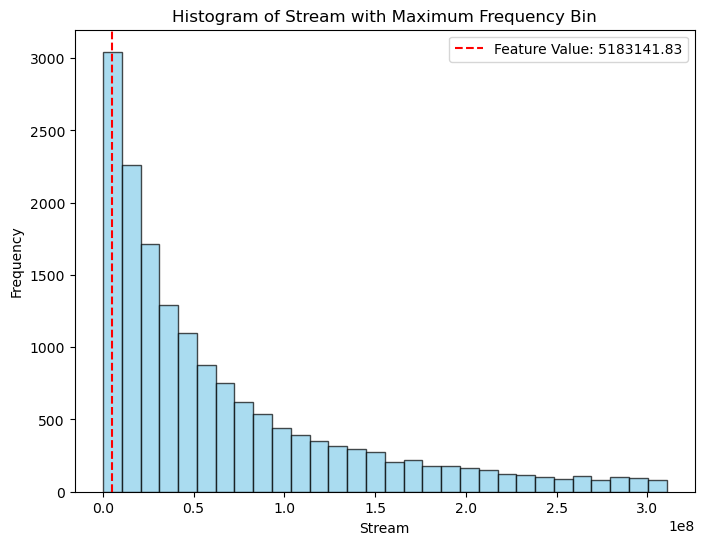

In [151]:
plt.figure(figsize=(8, 6))

counts, bins, _ = plt.hist(Spotify['Stream'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')

max_freq = counts.max()
max_bin_index = counts.argmax()
max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

plt.axvline(max_bin_center, color='red', linestyle='--', label=f'Feature Value: {max_bin_center:.2f}')

plt.xlabel('Stream')
plt.ylabel('Frequency')
plt.title('Histogram of Stream with Maximum Frequency Bin')
plt.legend()

plt.show()

In [152]:
# Apply log transformation to the target variable
Spotify['Stream'] = np.log1p(Spotify['Stream'])

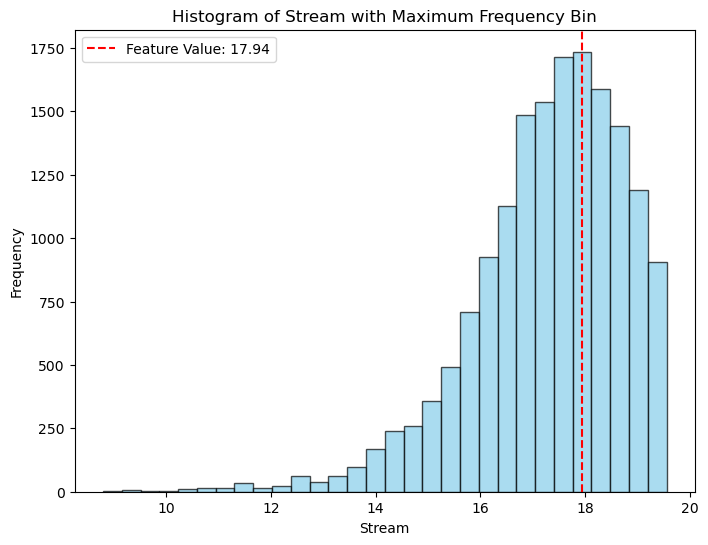

In [153]:
plt.figure(figsize=(8, 6))

counts, bins, _ = plt.hist(Spotify['Stream'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')

max_freq = counts.max()
max_bin_index = counts.argmax()
max_bin_center = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

plt.axvline(max_bin_center, color='red', linestyle='--', label=f'Feature Value: {max_bin_center:.2f}')

plt.xlabel('Stream')
plt.ylabel('Frequency')
plt.title('Histogram of Stream with Maximum Frequency Bin')
plt.legend()

plt.show()

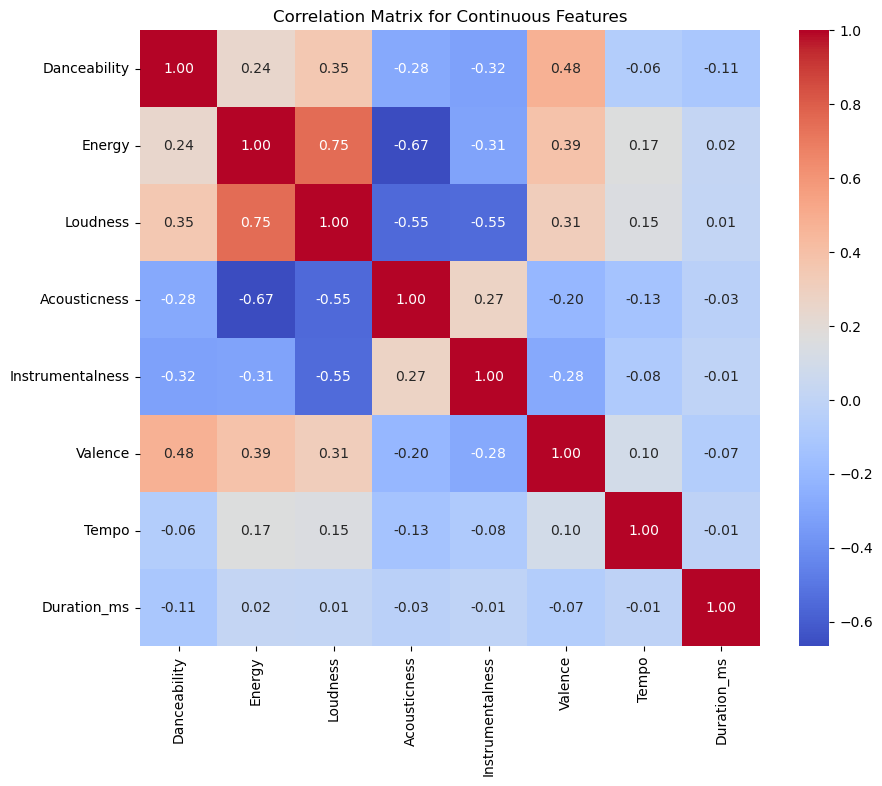

In [154]:
Spotify_x = Spotify.drop('Stream', axis=1)
Continuous = [feature for feature in Spotify_x.columns if Spotify_x[feature].dtype in ['float64']]

corr_matrix = Spotify_x[Continuous].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


Since Energy and Loudness, as well as Energy and Acousticness, are highly correlated, they essentially provide redundant information. To avoid multicollinearity and improve model performance, I will remove the Energy variable, keeping the more informative features in the dataset.

In [155]:
Spotify = Spotify[[
    'Artist', 
    #'Track', 'Album', 
    'Album_type', 'Danceability',#'Energy',
       #'Key', 
    'Loudness',
    'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness','Valence', 
    'Tempo', 'Duration_ms', 'Stream']].copy()

I am performing one-hot encoding on the categorical variables in the dataset. For each categorical feature, I generate binary columns that represent each category within the feature. This transformation allows machine learning models to interpret these features numerically, which is essential for modeling. After encoding, I drop the original categorical columns to avoid redundancy.

In [156]:
Spotify = Spotify.copy()

for feature in Categorical:
    encoded_columns = pd.get_dummies(Spotify[feature], prefix=feature)
    encoded_columns = encoded_columns.astype(int)
    Spotify = pd.concat([Spotify, encoded_columns], axis=1)
    Spotify.drop([feature], axis=1, inplace=True) 

print(Spotify.head(10))


    Danceability  Loudness  Acousticness  Instrumentalness  Valence     Tempo  \
1          0.676  0.857222      0.086900          0.000687    0.852  0.381149   
5          0.726  0.855716      0.007990          0.081000    0.462  0.575900   
6          0.625  0.828369      0.031500          0.081100    0.865  0.790132   
15         0.666  0.770219      0.002440          0.086000    0.776  0.376284   
22         0.925  0.879523      0.206000          0.000079    0.710  0.398641   
24         0.853  0.891014      0.071400          0.000000    0.659  0.386355   
25         0.892  0.927031      0.244000          0.000000    0.838  0.386137   
26         0.545  0.905684      0.368000          0.000000    0.574  0.746729   
28         0.386  0.917746      0.000012          0.000836    0.188  0.536516   
29         0.425  0.907401      0.000024          0.020200    0.282  0.415516   

    Duration_ms     Stream  Artist_Feature  Artist_Solo  Album_type_album  \
1      0.036423  19.552353     

Lasso regression offers several advantages over other models, particularly when dealing with high-dimensional datasets. The key benefit is its ability to perform both variable selection and regularization simultaneously. By applying L1 regularization, lasso can shrink the coefficients of less important features to zero, effectively removing them from the model. This not only helps with feature selection but also reduces model complexity. Additionally, lasso regression is computationally efficient, making it suitable for large datasets, and it can handle multicollinearity better than traditional linear regression by selecting a subset of highly influential features.

In [157]:
X = Spotify.drop(columns=['Stream'])
y = Spotify['Stream']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_model = Lasso(alpha=0.01)  #regularization strength

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Lasso Regression Mean Squared Error:", mse)

# Create a DataFrame mapping feature names to their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': lasso_model.coef_
})

# Sort by absolute coefficient value to see the most important features
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Print feature importance
print(feature_importance)

Lasso Regression Mean Squared Error: 1.7928360385742688
                   Feature   Coefficient
1                 Loudness  4.110713e-01
7           Artist_Feature  2.133740e-01
9         Album_type_album  2.041376e-01
13       Speechiness_Music  1.338287e-01
0             Danceability  0.000000e+00
15         Liveness_Studio  0.000000e+00
12     Speechiness_Mixture -0.000000e+00
10  Album_type_compilation  0.000000e+00
16           Liveness_live -0.000000e+00
6              Duration_ms  0.000000e+00
5                    Tempo  0.000000e+00
4                  Valence -0.000000e+00
8              Artist_Solo -2.197589e-16
2             Acousticness -1.274463e-01
11       Album_type_single -4.186328e-01
3         Instrumentalness -4.301325e-01
14      Speechiness_Speech -3.476592e+00


Evaluating the factors influencing a song’s performance on Spotify, the Lasso regression analysis reveals key insights. Songs that emphasize vocals and sound quality tend to perform well. Additionally, albums and tracks featuring collaborations with other artists generally outperform singles by solo artists. Conversely, songs with high speechiness (e.g., spoken word, audiobooks) and instrumentalness tend to have lower performance on the platform. Surprisingly, danceability, tempo, and song duration had no impact, suggesting that viral songs do not necessarily need to be short or highly dance

The model's Mean Squared Error (MSE) of 1.79 is particularly noteworthy, given that stream counts are measured in the millions. This indicates that the model is making relatively accurate predictions within a high-value range. These insights are instrumental for targeting feature optimization to maximize audience engagement and improve performance on Spotify.

Based on the analysis, here are key recommendations for artists looking to optimize their songs for better performance on Spotify:

* Focus Vocals and sound qaulity: racks with strong vocal elements and high production quality tend to perform better.
* Minimize Instrumentalness and Speech: Instrumental tracks, may struggle to keep listeners engaged compared to songs that feature prominent vocal elements. Similarly, content dominated by speech—such as spoken-word segments or rap is less popular among Spotify users who typically seek music-focused content.
* Release Full Albums: This encourages listeners to explore more of your work.
* Consider collaborations with other artists: Featuring other artists can expand audience reach, attract new listeners, and enhance a song’s discoverability.